# Iterating through all patients in all years to find peep>5

In [1]:
import pandas as pd
from datetime import datetime
import os
import pickle
from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time
from dateutil.relativedelta import relativedelta

from os.path import exists


import pandas as pd
import numpy as np
import os

import time


import json

import sys
from scipy.io import loadmat

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
import matplotlib.ticker as plticker

import seaborn as sns


import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PhysioMC/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
# from preprocessing import *
from ECG_module import *
from dataIO import *
from stage1_PPG_analysis import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
vital_window = 5 #min
min_threshold = 5 #min

In [3]:
%pwd

'/labs/kamaleswaranlab/Sepsis3_062321/mchan_analysis/disparities_O2/repo/stage1_SpO2_bed'

In [4]:
outputdir = '../../data/stage1_SpO2_bed/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [5]:
inputdir = '/labs/kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/'

In [6]:
David_inputdir = '/home/mchan82/kamaleswaranlab/Sepsis3_062321/dlin_analysis/'

# load csv files David prepared

## load the oxygen saturation data
### TODO: need to add FiO2 and PaO2 data

In [7]:
# FiO2 and PaO2? (PaO2 / FiO2 < 400 indicates respiratory problem)
oxygen_sat_filedir = '/home/mchan82/kamaleswaranlab/Sepsis3_062321/dlin_analysis/Pat_BedTime_List_some_on_BMI_2_6_22_spo2_sao2.csv'
df_oxygen_sat = pd.read_csv(oxygen_sat_filedir, index_col=0)  

In [8]:
mask = (df_oxygen_sat['Black']==1) | (df_oxygen_sat['White']==1)
df_oxygen_sat = df_oxygen_sat[mask]

In [9]:
df_oxygen_sat['times'] =  pd.to_datetime(df_oxygen_sat['times'], format="%Y-%m-%d %H:%M:%S")


In [10]:
df_oxygen_sat = df_oxygen_sat.rename(columns = {'pat_id':'PAT_ID', 'csn':'CSN'})
df_oxygen_sat

,index,spo2,sao2,times,Black,White,PAT_ID,CSN,csn_idx
0,4,97.0,96.5,2017-07-17 12:29:03,0.0,1.0,1842529.0,3885207198,45128.0
1,5,98.0,96.5,2017-07-17 13:29:03,0.0,1.0,1842529.0,3885207198,45128.0
2,6,95.0,96.5,2017-07-17 14:29:03,0.0,1.0,1842529.0,3885207198,45128.0
3,7,97.0,96.5,2017-07-17 15:29:03,0.0,1.0,1842529.0,3885207198,45128.0
4,8,97.0,96.5,2017-07-17 16:29:03,0.0,1.0,1842529.0,3885207198,45128.0
...,...,...,...,...,...,...,...,...,...
27,30,100.0,98.9,2018-03-29 08:00:47,1.0,0.0,99962669.0,58104308087,107482.0
28,31,100.0,98.9,2018-03-29 09:00:47,1.0,0.0,99962669.0,58104308087,107482.0
29,32,100.0,98.9,2018-03-29 10:00:47,1.0,0.0,99962669.0,58104308087,107482.0
30,33,98.0,98.9,2018-03-29 11:00:47,1.0,0.0,99962669.0,58104308087,107482.0


In [11]:
df_oxygen_sat.describe()

,index,spo2,sao2,Black,White,PAT_ID,CSN,csn_idx
count,200960.000000,200960.000000,200960.000000,200960.000000,200960.000000,2.009600e+05,2.009600e+05,200960.000000
mean,269.355608,97.045106,96.870626,0.408360,0.591640,6.553404e+07,3.652402e+10,48579.365013
std,361.627686,4.305423,3.633344,0.491532,0.491532,3.403954e+07,2.047750e+10,29484.596870
min,0.000000,0.000000,26.550000,0.000000,0.000000,1.842529e+06,6.669707e+07,73.000000
25%,45.000000,96.000000,96.200000,0.000000,0.000000,2.485274e+07,1.352412e+10,22993.000000
50%,136.000000,98.000000,97.900000,0.000000,1.000000,8.832823e+07,4.666620e+10,46759.000000
75%,350.000000,100.000000,98.800000,1.000000,1.000000,9.786810e+07,5.546849e+10,70885.000000
max,4426.000000,100.000000,100.750000,1.000000,1.000000,9.996267e+07,5.811763e+10,142522.000000


In [12]:
df_oxygen_sat['CSN'].unique().shape

(2290,)

## load the ind csv
### compute BED Time Diff (to show that we have much more bed data)
### show the median the time diffs

In [58]:
ind_filedir = '/home/mchan82/kamaleswaranlab/Sepsis3_062321/dlin_analysis/Pat_BedTime_List_some_on_BMI_2_6_22_ind.csv'
df_ind = pd.read_csv(ind_filedir, index_col=0)  

mask = (df_ind['Race String']=='African American  or Black') | (df_ind['Race String']=='Caucasian or White')
df_ind = df_ind[mask]

In [59]:
df_ind['DateStart'] = pd.to_datetime(df_ind['DateStart'], format="%Y-%m-%d %H:%M:%S")
df_ind['DateEnd'] = pd.to_datetime(df_ind['DateEnd'], format="%Y-%m-%d %H:%M:%S")

## TODO: change BED Time Difference

In [60]:
BED_LOCATION_START = pd.to_datetime(df_ind['BED_LOCATION_START'], format="%Y-%m-%d %H:%M:%S")
BED_LOCATION_END = pd.to_datetime(df_ind['BED_LOCATION_END'], format="%m/%d/%Y %H:%M:%S")

df_ind['BED_LOCATION_START'] = BED_LOCATION_START
df_ind['BED_LOCATION_END'] = BED_LOCATION_END


In [61]:
DateStart = pd.to_datetime(df_ind['DateStart'], format="%Y-%m-%d %H:%M:%S")
DateEnd = pd.to_datetime(df_ind['DateEnd'], format="%m/%d/%Y %H:%M:%S")

df_ind['DateStart'] = DateStart
df_ind['DateEnd'] = DateEnd

df_ind['BED Time Difference'] = (DateEnd-DateStart).dt.total_seconds()

In [62]:
print('EHR time diff: {:.2f}hr'.format(df_ind['Time Difference'].median()/60/60))
print('Waveform time diff: {:.2f}hr'.format(df_ind['BED Time Difference'].median()/60/60))

EHR time diff: -0.06hr
Waveform time diff: 42.28hr


In [68]:
df_ind['BED_LOCATION_START'].min(), df_ind['BED_LOCATION_START'].max()

(Timestamp('2017-01-27 15:28:19'), Timestamp('2018-03-29 06:02:41'))

In [69]:
df_ind['DateStart'].min(), df_ind['DateEnd'].max()

(Timestamp('2017-01-27 19:32:22'), Timestamp('2018-03-29 06:15:03'))

# merge df_ind with df_oxygen_sat so I can get deBedTime, DateStart, DateEnd, PAT_ID, White	Black, CSN, SaO2, SpO2, oxy sat. times in one column

## TODO: merge using the CSN instead 

In [19]:
df_merged = df_ind.merge(df_oxygen_sat[['spo2', 'sao2', 'times', 'PAT_ID', 'CSN']], on=['CSN', 'PAT_ID'], how='outer')
df_merged

,deBedTime,DateStart,DateEnd,PAT_ID,BED_LOCATION_START,BED_LOCATION_END,White,Black,Race String,Time Difference,Time Found,True Time Found,CSN Exist Flag,CSN,BED Time Difference,spo2,sao2,times
0,A118-0520880083,2018-03-12 18:41:23,2018-03-12 23:13:00,18004189.0,2018-03-12 18:41:39,2018-03-14 20:20:00,False,True,African American or Black,1235.0,2018-03-12 18:20:48,2018-03-12 11:20:48,True,3.967156e+10,16297.0,NaN,NaN,NaT
1,A118-0520896395,2018-03-12 23:13:15,2018-03-15 03:19:11,18004189.0,2018-03-12 18:41:39,2018-03-14 20:20:00,False,True,African American or Black,-453.0,2018-03-12 23:20:48,2018-03-12 11:20:48,True,3.967156e+10,187556.0,NaN,NaN,NaT
2,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,94.500000,92.4,2018-01-10 17:16:00
3,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,96.000000,92.4,2018-01-10 18:16:00
4,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,95.333333,92.4,2018-01-10 19:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390021,A106-0515603020,2018-01-10 16:50:19,2018-03-09 03:01:20,26319659.0,2017-12-28 02:51:36,2018-03-07 13:20:00,False,True,African American or Black,1741485.0,2017-12-21 13:05:34,2017-11-08 11:05:34,True,1.129628e+10,4961461.0,99.000000,97.3,2017-12-03 01:05:34
390022,A106-0515603020,2018-01-10 16:50:19,2018-03-09 03:01:20,26319659.0,2017-12-28 02:51:36,2018-03-07 13:20:00,False,True,African American or Black,1741485.0,2017-12-21 13:05:34,2017-11-08 11:05:34,True,1.129628e+10,4961461.0,99.000000,97.3,2017-12-03 02:05:34
390023,A106-0515603020,2018-01-10 16:50:19,2018-03-09 03:01:20,26319659.0,2017-12-28 02:51:36,2018-03-07 13:20:00,False,True,African American or Black,1741485.0,2017-12-21 13:05:34,2017-11-08 11:05:34,True,1.129628e+10,4961461.0,98.000000,97.3,2017-12-03 03:05:34
390024,A112-0515603023,2018-01-10 16:50:23,2018-03-02 16:11:07,21341087.0,2017-11-30 15:02:07,2018-03-02 08:48:00,True,False,Caucasian or White,-1636.0,2018-01-10 17:17:39,2017-11-25 14:17:39,True,1.042668e+10,4404044.0,NaN,NaN,NaT


In [20]:
(df_merged['DateEnd']=='1969-12-31 23:59:58').mean()

0.030838969709711662

In [21]:
(df_merged['DateEnd']>'1970-12-31 23:59:58').mean()

0.9691610302902883

# But simply merging them using PAT_ID is not ideal: same PAT_ID may have several deBedTime
## need to filter out rows incorrectly align by checking the timing
## only associate the demographic data to the ox sat. data when the timing match

In [22]:
DateStart = pd.to_datetime(df_merged['DateStart'], format="%Y-%m-%d %H:%M:%S") # str to datetime
DateEnd = pd.to_datetime(df_merged['DateEnd'], format="%Y-%m-%d %H:%M:%S")
times = pd.to_datetime(df_merged['times'], format="%Y-%m-%d %H:%M:%S")

In [23]:
# timedelta: int to datetime
mask = (times-timedelta(minutes=min_threshold) >= DateStart) & (times+timedelta(minutes=min_threshold) <= DateEnd)
df_merged = df_merged[mask]

In [24]:
print(mask.mean())

0.3821847774250947


In [25]:
df_merged['CSN'].unique().shape

(2117,)

In [26]:
df_merged['PAT_ID'].unique().shape

(2011,)

In [27]:
df_merged

,deBedTime,DateStart,DateEnd,PAT_ID,BED_LOCATION_START,BED_LOCATION_END,White,Black,Race String,Time Difference,Time Found,True Time Found,CSN Exist Flag,CSN,BED Time Difference,spo2,sao2,times
2,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,94.5,92.4,2018-01-10 17:16:00
3,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,96.0,92.4,2018-01-10 18:16:00
61,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,95.0,93.9,2018-01-10 22:16:00
62,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,94.0,93.9,2018-01-10 23:16:00
63,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,93.5,93.9,2018-01-11 00:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389367,A063-0493131179,2017-04-25 14:39:39,2017-05-18 20:01:09,47565503.0,2017-04-12 17:38:13,2017-05-18 16:05:00,True,False,Caucasian or White,-1521.0,2017-04-25 15:05:00,2017-04-08 21:05:00,True,1.326399e+10,2006490.0,98.0,99.1,2017-05-16 01:05:00
389368,A063-0493131179,2017-04-25 14:39:39,2017-05-18 20:01:09,47565503.0,2017-04-12 17:38:13,2017-05-18 16:05:00,True,False,Caucasian or White,-1521.0,2017-04-25 15:05:00,2017-04-08 21:05:00,True,1.326399e+10,2006490.0,98.0,99.1,2017-05-16 02:05:00
389369,A063-0493131179,2017-04-25 14:39:39,2017-05-18 20:01:09,47565503.0,2017-04-12 17:38:13,2017-05-18 16:05:00,True,False,Caucasian or White,-1521.0,2017-04-25 15:05:00,2017-04-08 21:05:00,True,1.326399e+10,2006490.0,100.0,99.1,2017-05-16 03:05:00
389370,A063-0493131179,2017-04-25 14:39:39,2017-05-18 20:01:09,47565503.0,2017-04-12 17:38:13,2017-05-18 16:05:00,True,False,Caucasian or White,-1521.0,2017-04-25 15:05:00,2017-04-08 21:05:00,True,1.326399e+10,2006490.0,94.0,99.1,2017-05-16 04:05:00


# What's in the rec_id folder 
    A043-0509992150_0037.mat: waveform data (ECG, PPG, resp. BP, etc.)
    A043-0509992150_0037.hea: header file of the waveform data (e.g. signal name, gain, unit, etc.)
    A043-0509992150_0037d.mat: header file of the waveform data in dictionary

    A043-0509992150_0000n.mat: vital sign data (HR, SpO2, etc.)
    A043-0509992150_0n.hea: header file of the vital sign  data
    A043-0509992150_0nd.mat: header file of the vital sign data in dictionary

# TODO: figure out what these are
    A043-0509992150_correction???
    A043-0509992150_layout.hea
    A043-0509992150.md5
    A043-0509992150.almth

In [28]:
# inputdir_rec

In [29]:
# os.listdir(inputdir)[0]

# playground

In [30]:
rec_id = 'A043-0509992150'
header_id = '0n'
# inputdir_rec = inputdir+rec_id + '/'

# load the header dict (this snippet works for both 0n.hea and 0000.hea

In [31]:
# >>> import datetime
# >>> d = datetime.date(2020, 2, 29)
# >>> d
# datetime.date(2020, 2, 29)
# >>> d + relativedelta(years=1)
# datetime.date(2021, 2, 28)

In [32]:
# header_dict

In [33]:
# df_bed, _ = get_df_bed(rec_id, inputdir, header_id=header_id)
# mask = (df_bed['HR'] >= label_range_dict['HR'][0]) & (df_bed['HR'] <= label_range_dict['HR'][1])
# df_bed = df_bed[mask]


In [34]:
# df_bed/

In [35]:
df_BedTime = df_merged[df_merged['deBedTime']=='A043-0509992150'].copy().reset_index(drop=True)


In [36]:
df_BedTime

,deBedTime,DateStart,DateEnd,PAT_ID,BED_LOCATION_START,BED_LOCATION_END,White,Black,Race String,Time Difference,Time Found,True Time Found,CSN Exist Flag,CSN,BED Time Difference,spo2,sao2,times
0,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,98.2,2017-11-06 18:56:00
1,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,98.2,2017-11-06 19:56:00
2,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,98.2,2017-11-06 20:56:00
3,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,98.2,2017-11-06 21:56:00
4,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,99.1,2017-11-06 22:56:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,99.0,96.5,2017-11-30 05:56:00
373,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,96.5,2017-11-30 06:56:00
374,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,96.5,2017-11-30 07:56:00
375,A043-0509992150,2017-11-06 18:15:50,2017-12-06 16:29:13,94166433.0,2017-11-06 13:13:34,2017-12-05 19:00:00,True,False,Caucasian or White,1190.0,2017-11-06 17:56:00,2017-11-05 12:56:00,True,4.991014e+10,2585603.0,100.0,96.5,2017-11-30 08:56:00


In [37]:
row = df_BedTime.loc[0,:].copy()

In [38]:
row

deBedTime                  A043-0509992150
DateStart              2017-11-06 18:15:50
DateEnd                2017-12-06 16:29:13
PAT_ID                          94166433.0
BED_LOCATION_START     2017-11-06 13:13:34
BED_LOCATION_END       2017-12-05 19:00:00
White                                 True
Black                                False
Race String             Caucasian or White
Time Difference                     1190.0
Time Found             2017-11-06 17:56:00
True Time Found        2017-11-05 12:56:00
CSN Exist Flag                        True
CSN                          49910137309.0
BED Time Difference              2585603.0
spo2                                 100.0
sao2                                  98.2
times                  2017-11-06 18:56:00
Name: 0, dtype: object

In [39]:
# header_dict

In [40]:
# # sanity check
# print('off time:', header_dict['DateStart_header'] - df_BedTime['DateStart'][0])


In [41]:
# # header_dict['Fs']

# (sync_start - header_dict['DateStart_header']).total_seconds()

# (sync_end - header_dict['DateStart_header']).total_seconds()

In [42]:




# i_sync_start = int((sync_start - header_dict['DateStart_header']).total_seconds() * header_dict['Fs'])
# i_sync_end = int((sync_end - header_dict['DateStart_header']).total_seconds() * header_dict['Fs'])



In [43]:
# plt.plot(df_bed['time'].values, df_bed['SPO2-%'].values)

In [44]:
# row

In [45]:


def append_vitals(row, df_bed, header_dict, main_vital='SPO2-%', verbose=False):


    
    # get the time and SaO2 value of the current row (from the ind.csv file David provided)
    t_SaO2 = row['times']
    SaO2 = row['sao2']
    rec_id = row['deBedTime']

    if verbose:
        print('\tcheck SaO2 time and value: ', t_SaO2, SaO2)
    sync_start  = t_SaO2 - timedelta(minutes=vital_window)
    sync_end = t_SaO2

    # double check if t_SaO2, sync_start, sync_end are computed correctly
    # print('t_SaO2, sync_start, sync_end:', t_SaO2, sync_start, sync_end)

    # # get df_bed
    
#     start = time.time()

    
#     end = time.time()
#     print('get_df_bed', end - start)

    
    
    # select the right time range within the vital sign dataset 
    mask_SaO2_window = (df_bed['time'] >= (sync_start - header_dict['DateStart_header']).total_seconds()) & (df_bed['time'] <= (sync_end - header_dict['DateStart_header']).total_seconds())
    df_bed = df_bed[mask_SaO2_window]
    
    if main_vital not  in df_bed.columns:        
        if verbose:
            print('\t[error] SpO2 not in dataframe')
        row['merged_message'] = '[DNE] '+main_vital
        return row

    # select df_bed with reasonable SPO2 range, define in label_range_dict
    mask_SpO2 = (df_bed[main_vital] >= label_range_dict['SPO2'][0]) & (df_bed[main_vital] <= label_range_dict['SPO2'][1])
    df_bed = df_bed[mask_SpO2].reset_index(drop=True)
    
    if df_bed.shape[0]==0:
        if verbose:
            print('\t[error] SpO2 outside normal range')
        # return None, '[out of range] '+main_vital
        row['merged_message'] =  '[out of range] '+main_vital
        return row


    # get the index closest to sao2 ground truth while closest to its sample time
    diff_arr = np.absolute(df_bed[main_vital].values-SaO2)
    i_min = np.where(diff_arr == diff_arr.min())[0][-1]
    
    # i_min = 0
    # get the row for this index
    
    selected_columns = list(set(vital_names).intersection(list(df_bed.columns)))
    row_vitals = df_bed.loc[i_min, selected_columns+['time']].rename({"time": "time_vital"})
    
    # print(df_bed.loc[i_min,:])
    # sys.exit()

    row_vitals['time_vital'] = header_dict['DateStart_header'] + timedelta(seconds=row_vitals['time_vital'])
    

    row_appended = pd.concat([row, row_vitals], axis=0)

    row_appended['merged_message'] =  '[perfecto] ' + main_vital
        # return row
    # row_vitals['time_vital']
    return row_appended


'/labs/kamaleswaranlab/Sepsis3_062321/Files_cp_sftp_6_30_21/Files_cp_6_30_21/'

In [117]:
# df_BedTime

In [ ]:
df_merged_appended = pd.DataFrame()


# vital_names=  ['SPO2-%']
vital_names=  ['SPO2-%', 'HR', 'RESP', 'NBP-S', 'NBP-D', 'NBP-M']
main_vital = 'SPO2-%'

# rec_id = 'A043-0509992150'
# header_id = '0n'
header_id = '0n'

verbose = False
# verbose = True

for rec_id in df_merged['deBedTime'].unique():
    
    # start = time.time()

    df_BedTime = df_merged[df_merged['deBedTime']==rec_id].copy().reset_index(drop=True)
    print(rec_id)


    # get header_dict for this rec_id abd header_id
    inputdir_rec = inputdir + rec_id + '/'
    if exists(inputdir_rec)==False:
        if verbose:
            print('\t\t[DNE] bed data folder does not exist')
            
        df_BedTime['merged_message'] = '[DNE] bed'
        df_merged_appended = pd.concat([df_merged_appended,df_BedTime.T], axis=1)
        continue
        
    # 2. get header file directory
    headerdir = inputdir_rec + rec_id + '_' + header_id + '.hea'

    

    if exists(headerdir)==False:
        if verbose:
            print('\t\t[DNE] vital sign data headerdir does not exist')

        df_BedTime['merged_message'] = '[DNE] vital'
        df_merged_appended = pd.concat([df_merged_appended,df_BedTime.T], axis=1)
        continue
        

    # get the vital data
    df_bed, header_dict_raw = get_df_bed(rec_id, inputdir, header_id=header_id)

    gain_dict = header_dict_raw['gain_dict']
    
    if main_vital not in gain_dict.keys():
        if verbose:
            print('\t\t[{}] DNE'.format(main_vital))

        df_BedTime['merged_message'] = '[DNE] '+main_vital
        df_merged_appended = pd.concat([df_merged_appended,df_BedTime.T], axis=1)
        continue

    if gain_dict[main_vital]==0:
        if verbose:
            print('\t\t[gain_error] gain is 0')

        df_BedTime['merged_message'] = '[gain_error] vital'
        df_merged_appended = pd.concat([df_merged_appended,df_BedTime.T], axis=1)
        continue
    


    # load header file
    with open(headerdir, 'r') as f:
        header = f.readlines()

    header_dict = header_extract(header)

    # correct for 30yr off
    header_dict['DateStart_header'] = header_dict['date']+' '+header_dict['start_time']
    header_dict['DateStart_header'] = datetime.strptime(header_dict['DateStart_header'], '%d/%m/%Y %H:%M:%S.%f') + relativedelta(years=vital_yearoff)
    # header_dict['DateStart_header']
    

    # aaa = df_BedTime.loc[:5,:].copy()
    for index, row in df_BedTime.iterrows():
        row_appended = append_vitals(row, df_bed,header_dict, main_vital=main_vital,verbose=verbose)
        # if row_vitals is not None:
        #     row_appended = pd.concat([row, row_vitals], axis=0)
        df_merged_appended = pd.concat([df_merged_appended,row_appended], axis=1)
            
    # if 'A140' not in rec_id:
    #     print(row_appended)

    
    # # 9. store the features
    # # outputdir_recording = outputdir+rec_id+'/'
    # outputdir_recording = outputdir+rec_id+'_'+str(int(row['CSN']))+'/'
    # if not os.path.exists(outputdir_recording):
    #     os.makedirs(outputdir_recording)

    df_merged_appended.T.reset_index(drop=True).to_csv(outputdir+'df_merged_appended.csv.gz', index=False, compression='gzip')
    
    
    # end = time.time()
    # print('get vital', end - start)

df_merged_appended = df_merged_appended.T.reset_index(drop=True)

A140-0515603029
A140-0515620983
A088-0516752917
A028-0495319861
A096-0508384730
A092-0509027339
A040-0506890587
A050-0504549802
A050-0504562139
A108-0518398746
A108-0518416829
A117-0520655417
A069-0499681713
A069-0499694449
A094-0499813593
A070-0513720061
A070-0513732305
A006-0496715149
A021-0507858656
A021-0507403282
A091-0501562346
A070-0489631783
A088-0493334952
A103-0493843476
A053-0500924173
A037-0503615376
A110-0516977186
A110-0516994335
A014-0494015306
A014-0494004666
A014-0494028963
A069-0494452027
A069-0494464877
A104-0516827109
A104-0516846420
A060-0516834366
A132-0522270480
A012-0514952815
A092-0515538039
A014-0500324698
A026-0501729641
A062-0519529481
A013-0517960375
A088-0519432015
A085-0519682132
A004-0493526508
A080-0490292486
A080-0490295354
A058-0519249333
A088-0496780311
A088-0496795960
A076-0502840154
A037-0499216381
A092-0500306895
A037-0499238417
A037-0499124198
A078-0515618854
A096-0505485457
A065-0505512498
A093-0521831911
A062-0495226136
A054-0490743104
A064-048

/labs/kamaleswaranlab/Sepsis3_062321/mchan_analysis/disparities_O2/repo/stage1_SpO2_bed/../PhysioMC/dataIO.py:102: RuntimeWarning: divide by zero encountered in true_divide
  raw_dict[sig_name] = data[i, :]/gain_dict[sig_name]
/labs/kamaleswaranlab/Sepsis3_062321/mchan_analysis/disparities_O2/repo/stage1_SpO2_bed/../PhysioMC/dataIO.py:102: RuntimeWarning: invalid value encountered in true_divide
  raw_dict[sig_name] = data[i, :]/gain_dict[sig_name]


A063-0500278805
A050-0499792023
A045-0501121086
A111-0520457503
A025-0517845298
A059-0519968069
A084-0490115896
A084-0490119267
A084-0490047849
A076-0498974796
A064-0490943346
A069-0499821077
A062-0497644613
A024-0497497332
A007-0495234892
A006-0506618574
A006-0506623918
A075-0494910386
A018-0501936824
A065-0496526488
A050-0505124547
A068-0503024224
A063-0508526330
A111-0521759523
A078-0506721009
A058-0494488348
A083-0499113429
A047-0494444776
A020-0493236343
A020-0493131181
A098-0490202636
A057-0508446555
A037-0494005667
A053-0503969400
A077-0503934145
A038-0505678589
A037-0502828595
A098-0502848845
A086-0496446095
A035-0505011852
A015-0508193640
A032-0499122259
A106-0521265126
A040-0505328689
A011-0493358278
A078-0499352861
A034-0520792201
A092-0504405222
A052-0506139075
A052-0505333121
A040-0505425779
A015-0506016182
A007-0504046156
A059-0506864242
A032-0508865602
A084-0496426175
A051-0498340427
A040-0493670212
A012-0486184701
A043-0499892279
A082-0506471830
A038-0506467061
A077-049

In [93]:
print('done')

done


In [147]:
df_merged_appended['DateStart'].min(), df_merged_appended['DateStart'].max()

(Timestamp('2017-01-27 19:32:22'), Timestamp('2018-03-28 20:54:40'))

In [148]:
df_merged_appended['DateEnd'].min(), df_merged_appended['DateEnd'].max()

(Timestamp('2017-03-02 19:06:53'), Timestamp('2018-03-29 06:15:03'))

,deBedTime,DateStart,DateEnd,PAT_ID,BED_LOCATION_START,BED_LOCATION_END,White,Black,Race String,Time Difference,Time Found,True Time Found,CSN Exist Flag,CSN,BED Time Difference,spo2,sao2,times,SPO2-%,time_vital,merged_message,t_diff_sao2_SPO2-%(s)
0,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,94.5,92.4,2018-01-10 17:16:00,95.0,2018-01-10 17:14:09,[perfecto] SPO2-%,111.0
1,A140-0515603029,2018-01-10 16:50:29,2018-01-10 19:03:47,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1531.0,2018-01-10 17:16:00,2017-12-18 21:16:00,True,4.991014e+10,7998.0,96.0,92.4,2018-01-10 18:16:00,96.0,2018-01-10 18:13:19,[perfecto] SPO2-%,161.0
2,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,95.0,93.9,2018-01-10 22:16:00,93.0,2018-01-10 22:15:59,[perfecto] SPO2-%,1.0
3,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,94.0,93.9,2018-01-10 23:16:00,94.0,2018-01-10 23:15:35,[perfecto] SPO2-%,25.0
4,A140-0515620983,2018-01-10 21:49:43,2018-01-21 21:51:58,94166433.0,2018-01-10 16:50:12,2018-01-18 21:15:32,True,False,Caucasian or White,-1577.0,2018-01-10 22:16:00,2017-12-18 21:16:00,True,4.991014e+10,950535.0,93.5,93.9,2018-01-11 00:16:00,94.0,2018-01-11 00:13:13,[perfecto] SPO2-%,167.0


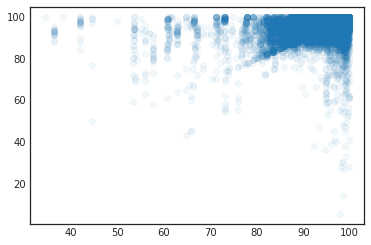

In [150]:
# read csv
David_inputdir  = '/home/mchan82/kamaleswaranlab/Sepsis3_062321/dlin_analysis/'
df_merged_appended = pd.read_csv(David_inputdir+'df_merged_appended.csv.gz')  

# compute time difference between sao2 and SPO2-%
t_diff = (pd.to_datetime(df_merged_appended['times'], format="%Y-%m-%d %H:%M:%S") - pd.to_datetime(df_merged_appended['time_vital'], format="%Y-%m-%d %H:%M:%S")).dt.total_seconds()
df_merged_appended['t_diff_sao2_SPO2-%(s)'] = t_diff

plt.scatter(df_merged_appended['sao2'].values, df_merged_appended['SPO2-%'].values, alpha=0.05)

# show df_merged_appended
df_merged_appended.head()

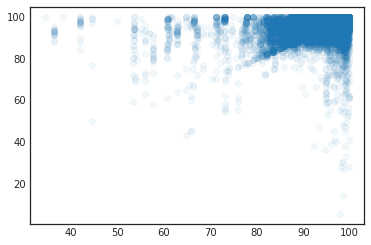

# save to David's repo

In [153]:
David_inputdir+'df_merged_appended.csv.gz'

'/home/mchan82/kamaleswaranlab/Sepsis3_062321/dlin_analysis/df_merged_appended.csv.gz'

In [151]:
df_merged_appended = pd.read_csv(outputdir+'df_merged_appended.csv.gz')  

# save in David dir
df_merged_appended.to_csv(David_inputdir+'df_merged_appended.csv.gz', index=False, compression='gzip')


t_diff = (pd.to_datetime(df_merged_appended['times'], format="%Y-%m-%d %H:%M:%S") - pd.to_datetime(df_merged_appended['time_vital'], format="%Y-%m-%d %H:%M:%S")).dt.total_seconds()
df_merged_appended['t_diff_sao2_SPO2-%(s)'] = t_diff

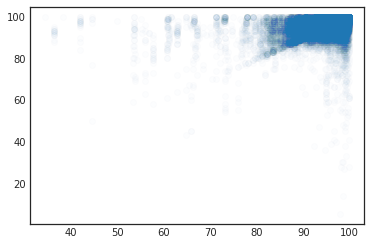

In [178]:
def inspect_vitals(df_bed, vital_names):
    
    fig, axes = plt.subplots(len(vital_names),1,figsize=(6,len(vital_names)*1.5))

    for i, vital_name in enumerate(vital_names):
        # fig, ax = plt.subplots(1,1,figsize=(6,2))
        ax = axes[i]
        ax.plot(df_bed['time'].values, df_bed[vital_name].values)
        ax.set_title(vital_name)
        
    fig.tight_layout()

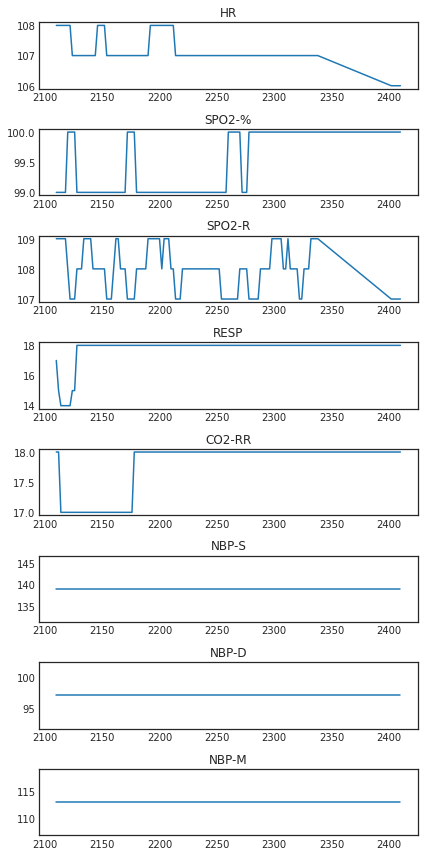

In [180]:
inspect_vitals(df_bed, vital_names)


# check the total duration of a waveform given inputdir_rec

In [62]:
    # os.listdir(inputdir_rec)

def check_waveform_dur(inputdir_rec):

    t_dur_total = 0
    for header_name in sorted(os.listdir(inputdir_rec)):
        if '.hea' not in header_name:
            continue

        if '_' not in header_name:
            continue

        if '_0n' in header_name:
            continue
        if 'layout' in header_name:
            continue

        # print(header_name)
        headerdir = inputdir_rec + header_name


        header_id = header_name.split('_')[-1].split('.hea')[0]


        with open(headerdir, 'r') as f:
            header = f.readlines()

        header_dict = header_extract(header)


        # print(header_id, header_dict['t_dur(hr)'])

        t_dur_total+=  header_dict['t_dur(hr)']

    return t_dur_total # in hours

0000 8.0
0001 7.983333333333333
0002 8.0
0003 8.0
0004 8.0
0005 8.0
0006 8.0
0007 8.0
0008 8.0
0009 8.0
0010 7.982777777777778
0011 8.0
0012 8.0
0013 8.0
0014 8.0
0015 8.0
0016 8.0
0017 8.0
0018 8.0
0019 8.0
0020 8.0
0021 8.0
0022 8.0
0023 8.0
0024 8.0
0025 8.0
0026 8.0
0027 0.3777777777777778
0028 0.95
0029 8.0
0030 8.0
0031 4.85
0032 8.0
0033 8.0
0034 8.0
0035 3.433333333333333
0036 8.0
0037 8.0
0038 8.0
0039 8.0
0040 8.0
0041 7.982777777777778
0042 8.0
0043 8.0
0044 8.0
0045 8.0
0046 8.0
0047 0.9161111111111111
0048 8.0
0049 8.0
0050 8.0
0051 8.0
0052 8.0
0053 8.0
0054 8.0
0055 8.0
0056 8.0
0057 8.0
0058 8.0
0059 8.0
0060 8.0
0061 8.0
0062 8.0
0063 8.0
0064 8.0
0065 8.0
0066 8.0
0067 8.0
0068 8.0
0069 8.0
0070 8.0
0071 8.0
0072 8.0
0073 8.0
0074 8.0
0075 8.0
0076 8.0
0077 8.0
0078 8.0
0079 7.995
0080 8.0
0081 8.0
0082 8.0
0083 8.0
0084 8.0
0085 8.0
0086 8.0
0087 8.0
0088 6.247777777777778
0089 8.0
0090 7.350555555555556
0091 0.08
29.00622685185185
